# Описание признаков

* SeriousDlqin2yrs - Человек просрочил платеж на 90 и более дней - yes/no - *выходной признак*
* RevolvingUtilizationOfUnsecuredLines - Общий баланс по кредитным картам и кредитам, за исключением кредита по недвижимости, деленный на сумму кредитных лимитов - проценты
* Age - возраст заемщика - целое число
* NumberOfTime30-59DaysPastDueNotWorse - Количество случаев, когда заемщик просрочил платеж на 30-59 дней (но не более) за последние 2 года - целое число
* DebtRatio - Ежемесячные выплаты по долгам, алименты, расходы на проживание, деленные на валовой доход в месяц - проценты
* MonthlyIncome - Ежемесячный доход - вещественное число
* NumberOfOpenCreditLinesAndLoans - Количество открытых кредитов (например, автокредит или ипотека) и кредитных линий (например, кредитные карты) - целое число
* NumberOfTimes90DaysLate - Количество случаев, когда заемщик просрочил платеж на 90 и более дней за последние 2 года - целое число
* NumberRealEstateLoansOrLines - Количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии на покупку жилья - целое число
* NumberOfTime60-89DaysPastDueNotWorse - Количество случаев, когда заемщик просрочил платеж на 60-89 дней (но не более) за последние 2 года - целое число
* NumberOfDependents - Количество иждивенцев в семье, исключая заемщика (супруга, детей и т.д.) - целое число


#Работа с данными

Загрузите данные

Проведите предобработку данных

Проведите масштабирование признаков, если это необходимо

Разделите данные на обучающую и контрольную выборки

In [1]:
# раскоментить установку catboost, если отсутствует
#%%capture
%pip install catboost
%pip install seaborn
%pip install sklearn
%pip install Jinja2

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.sustech.edu.cn/pypi/simple
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip



Looking in indexes: https://mirrors.sustech.edu.cn/pypi/simple
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.sustech.edu.cn/pypi/simple
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://mirrors.sustech.edu.cn/pypi/simple
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# общие
import pandas as pd
import numpy as np
#from google.colab import drive

# визуализация
from matplotlib import pyplot as plt
import seaborn as sns

# модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
import catboost


# метрики
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve

# утилиты
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
#drive.mount('/content/drive')
#data_train = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Misis_ MO/hw1/cs-training.csv')
#data_test = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Misis_ MO/hw1/cs-test.csv')
data_train = pd.read_csv('C:/Users/Leo/Desktop/Misis/ML_1_sem/Project_1/cs-training.csv', index_col=0)
data_test = pd.read_csv('C:/Users/Leo/Desktop/Misis/ML_1_sem/Project_1/cs-test.csv', index_col=0)

Разделим числовые признаки и категориальные.

In [4]:
# Числовые признаки
num_cols = [
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'DebtRatio',
    'MonthlyIncome'
]

# Категориальные признаки
cat_cols = [
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents'
]
# Все признаки 
feature_cols = num_cols + cat_cols
# Таргет признак 
target_col = 'SeriousDlqin2yrs'

## Обединение датасетов

In [5]:
data_test["test"] = 1
data_train["test"] = 0
data_global = pd.concat([data_test,data_train])
data_global

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,test
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0,1
2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0,1
3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0,1
4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0,1
5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
149996,0.0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0,0
149997,0.0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0,0
149998,0.0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0,0
149999,0.0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0,0


## Анализ данных

In [6]:
data_global.isna().sum()

SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            49834
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        6550
test                                         0
dtype: int64

In [7]:
data_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251503 entries, 1 to 150000
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  float64
 1   RevolvingUtilizationOfUnsecuredLines  251503 non-null  float64
 2   age                                   251503 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  251503 non-null  int64  
 4   DebtRatio                             251503 non-null  float64
 5   MonthlyIncome                         201669 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       251503 non-null  int64  
 7   NumberOfTimes90DaysLate               251503 non-null  int64  
 8   NumberRealEstateLoansOrLines          251503 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  251503 non-null  int64  
 10  NumberOfDependents                    244953 non-null  float64
 11  

Приведенная ниже карта демонстрирует паттерн пропущенных значений для всех признаков набора. По горизонтальной оси расположены признаки, по вертикальной – количество записей/строк. Желтый цвет соответствует пропускам данных

<AxesSubplot:>

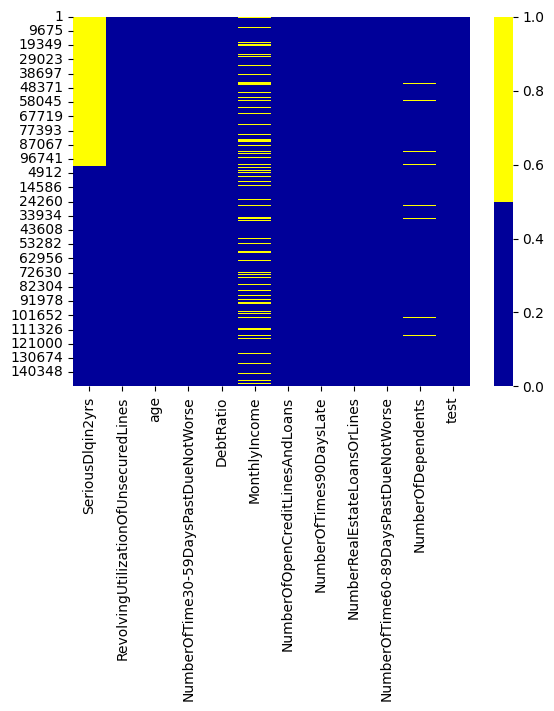

In [8]:
cols = data_global.columns[:]
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099','#ffff00'] 
sns.heatmap(data_global[cols].isnull(), cmap=sns.color_palette(colours))

In [9]:
data_global.isna().sum()

SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            49834
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        6550
test                                         0
dtype: int64

Посмотрим на пробелы в данных

<AxesSubplot:>

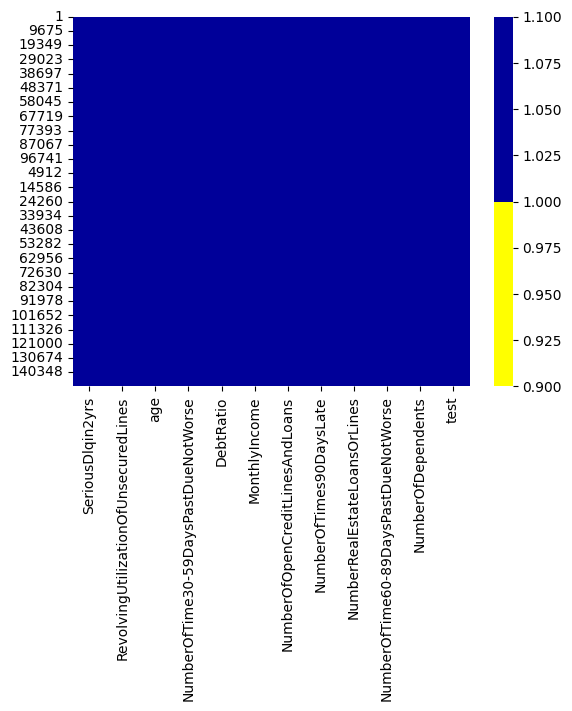

In [10]:
cols = data_global.columns[:]
# определяем цвета 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#ffff00', '#000099'] 
sns.heatmap(data_global[cols] != " ", cmap=sns.color_palette(colours))

Заменим NaN на среднее значение по столбцу

In [11]:
data_global.MonthlyIncome = data_global.MonthlyIncome.replace(np.NaN,data_global.MonthlyIncome.mean())
data_global.NumberOfDependents = data_global.NumberOfDependents.replace(np.NaN,data_global.NumberOfDependents.mean())

In [12]:
data_global.isna().sum()

SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                                0
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                           0
test                                         0
dtype: int64

## Обработка выбросов

### Числовые признаки

In [13]:
for name in num_cols:
  print(data_global[name].describe())
  print()

count    251503.000000
mean          5.750415
std         229.633980
min           0.000000
25%           0.029977
50%           0.153575
75%           0.561293
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

count    251503.000000
mean         52.339694
std          14.775120
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

count    251503.000000
mean        349.562468
std        1884.792016
min           0.000000
25%           0.174330
50%           0.365612
75%           0.861754
max      329664.000000
Name: DebtRatio, dtype: float64

count    2.515030e+05
mean     6.744818e+03
std      2.302918e+04
min      0.000000e+00
25%      3.900000e+03
50%      6.598000e+03
75%      7.385000e+03
max      7.727000e+06
Name: MonthlyIncome, dtype: float64



Можем наблюда выбросы, давайте обработаем их

In [14]:
test_0 = data_global.loc[data_global.test == 0]
test_1 = data_global.loc[data_global.test == 1]
for name in num_cols:
  upper_lim = test_0[name].quantile(.98)
  lower_lim = test_0[name].quantile(.02)
  test_0 = test_0[(test_0[name] < upper_lim) & (test_0[name] > lower_lim)]
data_global = test_1.append(test_0)

C:\Users\Leo\AppData\Local\Temp\ipykernel_6816\771503585.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_global = test_1.append(test_0)


In [15]:
data_global.reset_index(drop=True)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,test
0,NaN,0.885519,43,0,0.177513,5700.000000,4,0,0,0,0.0,1
1,NaN,0.463295,57,0,0.527237,9141.000000,15,0,4,0,2.0,1
2,NaN,0.043275,59,0,0.687648,5083.000000,12,0,1,0,2.0,1
3,NaN,0.280308,38,1,0.925961,3200.000000,7,0,2,0,0.0,1
4,NaN,1.000000,27,0,0.019917,3865.000000,4,0,0,0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
220840,0.0,0.385742,50,0,0.404293,3400.000000,7,0,0,0,0.0,0
220841,0.0,0.040674,74,0,0.225131,2100.000000,4,0,1,0,0.0,0
220842,0.0,0.299745,44,0,0.716562,5584.000000,4,0,1,0,2.0,0
220843,0.0,0.246044,58,0,3870.000000,6744.818167,18,0,1,0,0.0,0


Теперь посмотрим на новое распределение

In [16]:
for name in num_cols:
  print(data_global[name].describe())
  print('='*45)

count    220845.000000
mean          2.614575
std         133.006472
min           0.000000
25%           0.038000
50%           0.167024
75%           0.553160
max       21821.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64
count    220845.000000
mean         52.373601
std          13.964833
min          21.000000
25%          42.000000
50%          52.000000
75%          62.000000
max         104.000000
Name: age, dtype: float64
count    220845.000000
mean        287.239221
std        1219.230106
min           0.000000
25%           0.188917
50%           0.371085
75%           0.793856
max      268326.000000
Name: DebtRatio, dtype: float64
count    2.208450e+05
mean     6.598809e+03
std      2.228574e+04
min      0.000000e+00
25%      4.000000e+03
50%      6.600000e+03
75%      7.500000e+03
max      7.727000e+06
Name: MonthlyIncome, dtype: float64


### Категориальные признаки

6


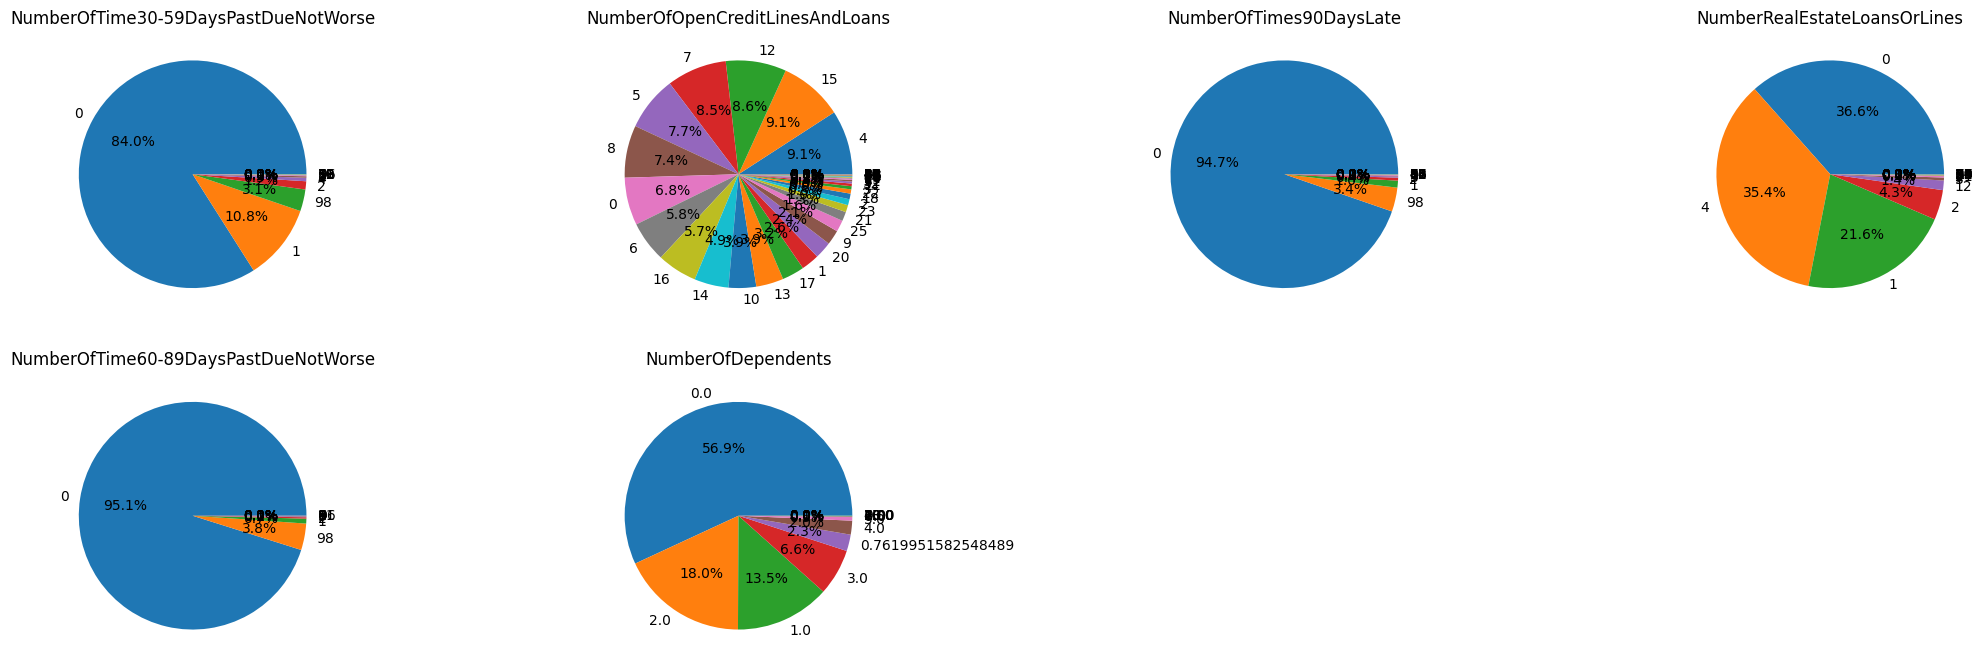

In [17]:
plt.figure(figsize=(27,17))
print(len(cat_cols))
for i, name in enumerate(cat_cols):
    s = data_global[name].value_counts()
    my_labels = data_global[name].unique()
    plt.subplot(4, 4, i+1,title = name)
    plt.pie(s,labels = my_labels,autopct='%1.1f%%')
plt.show()

In [18]:
for name in cat_cols:
  print(data_global[name].describe())
  print('Уникальные значения:')
  print(sorted(data_global[name].unique()))
  print('='*45)

count    220845.000000
mean          0.361136
std           3.423324
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: float64
Уникальные значения:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 19, 96, 98]
count    220845.000000
mean          8.674441
std           5.109979
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          85.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64
Уникальные значения:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 63, 85]
count    220845.000000
mean          0.200756
std           3.388855
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          98.000000
Nam

In [19]:
# для нормирования числовых признаков
scaler = StandardScaler()

In [20]:
# Проведем масштабирование числовых признаков
data_global[num_cols] = scaler.fit_transform(data_global[num_cols])

## Разделение датасетов
Разделим обратно на train и test

In [21]:
data_test = data_global[data_global.test == 1]
data_train = data_global[data_global.test == 0]

data_test = data_test.drop(columns = ['test','SeriousDlqin2yrs'])
data_train_Y = data_train['SeriousDlqin2yrs']
data_train_X = data_train.drop(columns = ['test','SeriousDlqin2yrs'])

#Выбор и обучение модели

Выберите модель для классификации

Обучите модель и протестируйте на контрольной выборке

Выберите метрику качества, по которой будете оценивать модель

Произведите подбор параметров модели по сетке

## Необходимый функционал для сравнения моделей

Подготовим таблицу сравнения моделей

In [ ]:
# подготовим таблицу для оценок
models_score = {}
models_score['model_name'] = []
models_score['roc_auc'] = []
models_score['accuracy'] = []
models_score['precision'] = []
models_score['recall'] = []

Сделаем функцию для удобного подсчета

In [ ]:
def ml_result(model, name_mod, 
             X_train, X_valid, y_train, y_valid):

    # добавим имя в таблицу
    models_score['model_name'].append(name_mod)

    if name_mod == 'GradientBoostingRegressor':
      prob_train = model.predict(X_train)
      prob_valid = model.predict(X_valid)
    else:
      prob_train = model.predict_proba(X_train)[:, 1]
      prob_valid = model.predict_proba(X_valid)[:, 1]
      
    # метрики
    roc_auc_train = roc_auc_score(y_train,  prob_train)
    roc_auc_valid = roc_auc_score(y_valid, prob_valid)
    acc = accuracy_score(y_valid,(prob_valid >= 0.5))
    pec = precision_score(y_valid, (prob_valid >= 0.5))
    rec = recall_score(y_valid, (prob_valid >= 0.5))

    # добавим оценки в таблицу
    models_score['roc_auc'].append(roc_auc_valid)
    models_score['accuracy'].append(acc)
    models_score['precision'].append(pec)
    models_score['recall'].append(rec)

    # вывод лучших параметров 
    if name_mod != 'CatBoost':
      print('=' * 45)
      print("Лучшее значение всех параметров:",model.best_params_)
      print('=' * 45)
    else:
      print('=' * 45)

    # вывод влиятельных парметров данных
    #print("Лучшее значение парамеров в данных:",model.best_estimator_.feature_importance())
    #print('=' * 45)

    # вывод метрик
    print(f'Максимальное значение roc_auc на train: {roc_auc_train:.4f}')   
    print(f'Максимальное значение roc_auc на valid: {roc_auc_valid:.4f}')    
    print('=' * 45)
    print(f'Максимальное значение accuracy: {acc:.4f}')
    print(f'Максимальное значение precision: {pec:.4f}')
    print(f'Максимальное значение recall: {rec:.4f}')
    print('=' * 45)
    
    # вывод графика
    plt.figure(figsize=(10, 10))
    plt.plot(*roc_curve(y_train, prob_train)[:2], linestyle='-', label='train ROC AUC={:.4f}'.format(roc_auc_train))
    plt.plot(*roc_curve(y_valid, prob_valid)[:2], linestyle='-', label='test ROC AUC={:.4f}'.format(roc_auc_valid))

    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')

    legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")

    plt.show()

## LogisticRegression

In [ ]:
logistic_Reg = LogisticRegression()
# parameters = {'C':[100, 10, 1, 0.1, 0.01, 0.001], 'penalty' :['l1', 'l2']}
parameters = {'C':[100],'penalty' :['l2']}#best parametrs
              
X_train, X_valid, y_train, y_valid = train_test_split(scaler.fit_transform(data_train_X), data_train_Y, test_size=0.2, random_state=42)

log_regr = GridSearchCV(estimator=logistic_Reg, param_grid=parameters, scoring='roc_auc', n_jobs =-1)

In [ ]:
log_regr.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [100], 'penalty': ['l2']}, scoring='roc_auc')

Лучшее значение всех параметров: {'C': 100, 'penalty': 'l2'}
Максимальное значение roc_auc на train: 0.8312
Максимальное значение roc_auc на valid: 0.8310
Максимальное значение accuracy: 0.9390
Максимальное значение precision: 0.6425
Максимальное значение recall: 0.0763


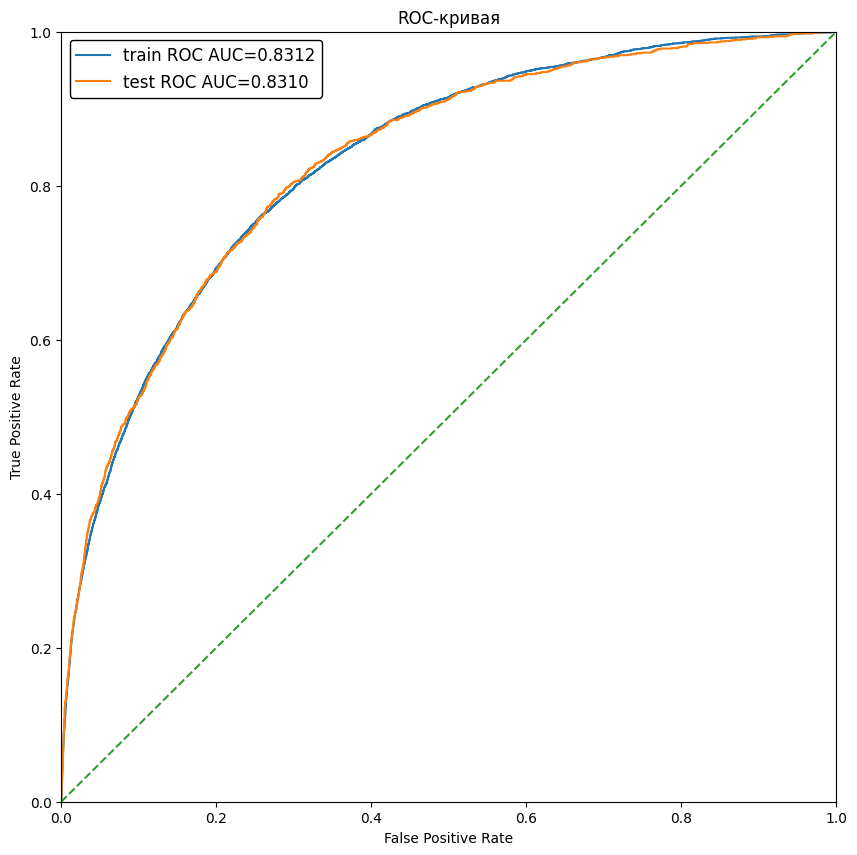

In [ ]:
ml_result(log_regr,'LogisticRegression',X_train, X_valid, y_train, y_valid)

## GradientBoostingRegressor

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(data_train_X, data_train_Y, test_size=0.2, random_state=42)
GBR = GradientBoostingRegressor()
# parameters = {'learning_rate': [0.01,0.02],
#                 'n_estimators' : [800,1000],
#                 'max_depth'    : [4,5,7,9]
#               }     
parameters = {'learning_rate': [0.01],# best parameters
              'n_estimators' : [800],
              'max_depth'    : [5]
              }
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, scoring='roc_auc',n_jobs =-1)

In [ ]:
grid_GBR.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01], 'max_depth': [5],
                         'n_estimators': [800]},
             scoring='roc_auc')

Лучшее значение всех параметров: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 800}
Максимальное значение roc_auc на train: 0.8714
Максимальное значение roc_auc на valid: 0.8530
Максимальное значение accuracy: 0.9400
Максимальное значение precision: 0.5980
Максимальное значение recall: 0.1558


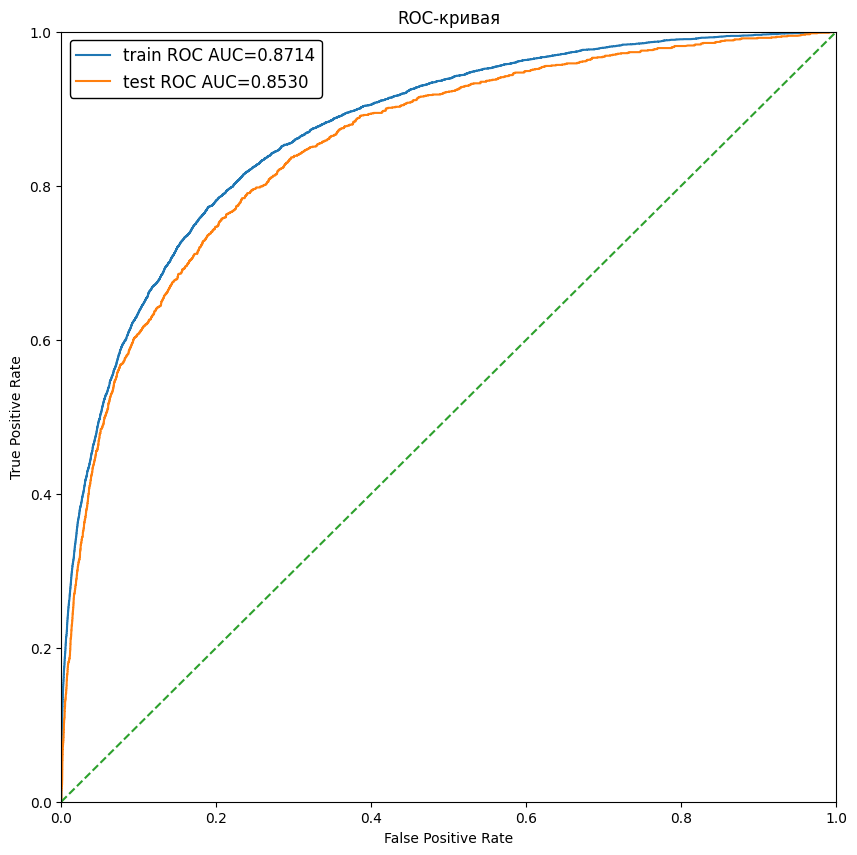

In [ ]:
ml_result(grid_GBR,'GradientBoostingRegressor',X_train, X_valid, y_train, y_valid)

## CatBoost

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(data_train_X, data_train_Y, test_size=0.2, random_state=42)
boosting_model = catboost.CatBoostClassifier(eval_metric = "AUC",
                                             early_stopping_rounds=50,# если значение не меняется 50 итераций, то переходим к след параметру
                                             iterations=1000
                                            #  task_type="GPU",
                                            #  devices='0:2'
                                             )
# PARAMS = {
#             'depth':[3,1,2,6,4,5,7,8,9,10],
#             'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
#             'l2_leaf_reg':[3,1,5,10,100]
# }
PARAMS = {
    "learning_rate":  [0.005]#best params

}

In [ ]:
boosting_model.grid_search(PARAMS, X_train, y_train, refit=True)

0:	test: 0.7800495	best: 0.7800495 (0)	total: 22.6ms	remaining: 22.6s
1:	test: 0.7943605	best: 0.7943605 (1)	total: 30.9ms	remaining: 15.4s
2:	test: 0.8397779	best: 0.8397779 (2)	total: 39.6ms	remaining: 13.2s
3:	test: 0.8479957	best: 0.8479957 (3)	total: 48.3ms	remaining: 12s
4:	test: 0.8506349	best: 0.8506349 (4)	total: 56.1ms	remaining: 11.2s
5:	test: 0.8490297	best: 0.8506349 (4)	total: 65.3ms	remaining: 10.8s
6:	test: 0.8481190	best: 0.8506349 (4)	total: 73.6ms	remaining: 10.4s
7:	test: 0.8501725	best: 0.8506349 (4)	total: 83ms	remaining: 10.3s
8:	test: 0.8498820	best: 0.8506349 (4)	total: 91.4ms	remaining: 10.1s
9:	test: 0.8496408	best: 0.8506349 (4)	total: 102ms	remaining: 10.1s
10:	test: 0.8487927	best: 0.8506349 (4)	total: 115ms	remaining: 10.3s
11:	test: 0.8487971	best: 0.8506349 (4)	total: 123ms	remaining: 10.1s
12:	test: 0.8497148	best: 0.8506349 (4)	total: 131ms	remaining: 9.98s
13:	test: 0.8514460	best: 0.8514460 (13)	total: 140ms	remaining: 9.83s
14:	test: 0.8512729	best

{'params': {'learning_rate': 0.005},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
              

Посмотрим на самые влиятельные параметры данных

In [ ]:
boosting_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,RevolvingUtilizationOfUnsecuredLines,38.145928
1,NumberOfTime30-59DaysPastDueNotWorse,15.664632
2,NumberOfTimes90DaysLate,12.622519
3,NumberOfTime60-89DaysPastDueNotWorse,7.594005
4,age,7.098598
5,DebtRatio,6.063704
6,NumberOfOpenCreditLinesAndLoans,5.839154
7,MonthlyIncome,3.110681
8,NumberRealEstateLoansOrLines,3.049656
9,NumberOfDependents,0.811123


Максимальное значение roc_auc на train: 0.8619
Максимальное значение roc_auc на valid: 0.8546
Максимальное значение accuracy: 0.9406
Максимальное значение precision: 0.6136
Максимальное значение recall: 0.1611


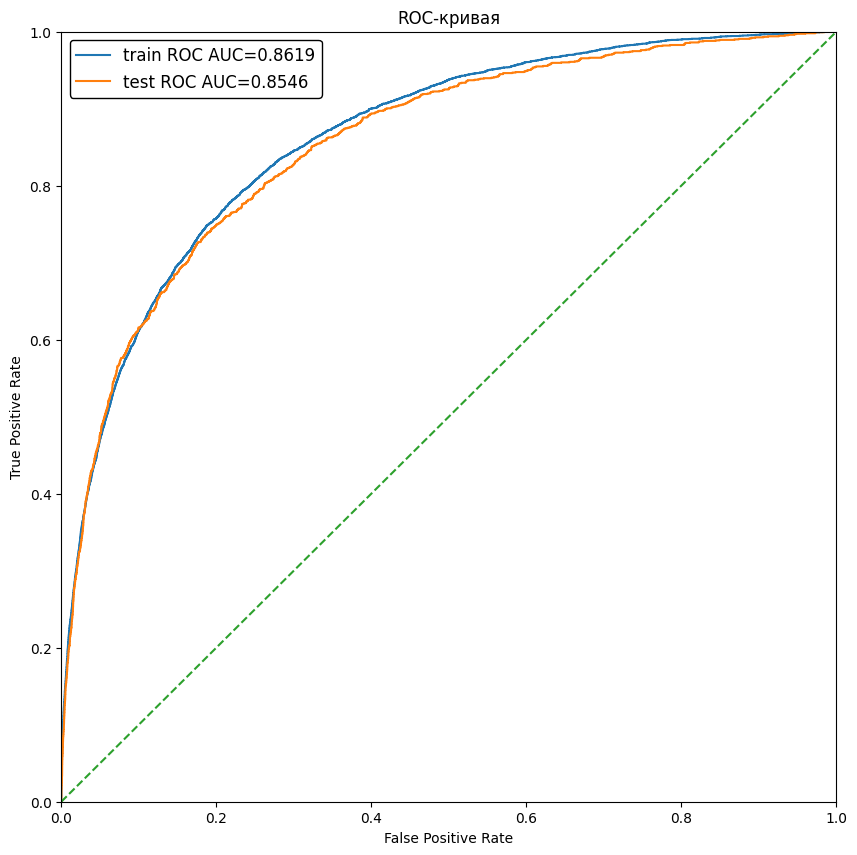

In [ ]:
ml_result(boosting_model,'CatBoost',X_train, X_valid, y_train, y_valid)

## RandomForestClassifier

In [ ]:
rand_for=RandomForestClassifier()
X_train, X_valid, y_train, y_valid = train_test_split(data_train_X, data_train_Y, test_size=0.2, random_state=42)
# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']
# }
param_grid = { 
    'n_estimators': [500],
    'max_features': ['auto'],
    'max_depth' : [8],
    'criterion' :['entropy']
}
RFC_model = GridSearchCV(estimator=rand_for, param_grid=param_grid, scoring='roc_auc', n_jobs =-1)

In [ ]:
RFC_model.fit(X_train, y_train)

C:\Users\Leo\AppData\Roaming\Python\Python310\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': [8],
                         'max_features': ['auto'], 'n_estimators': [500]},
             scoring='roc_auc')

Лучшее значение всех параметров: {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Максимальное значение roc_auc на train: 0.8746
Максимальное значение roc_auc на valid: 0.8531
Максимальное значение accuracy: 0.9404
Максимальное значение precision: 0.6412
Максимальное значение recall: 0.1280


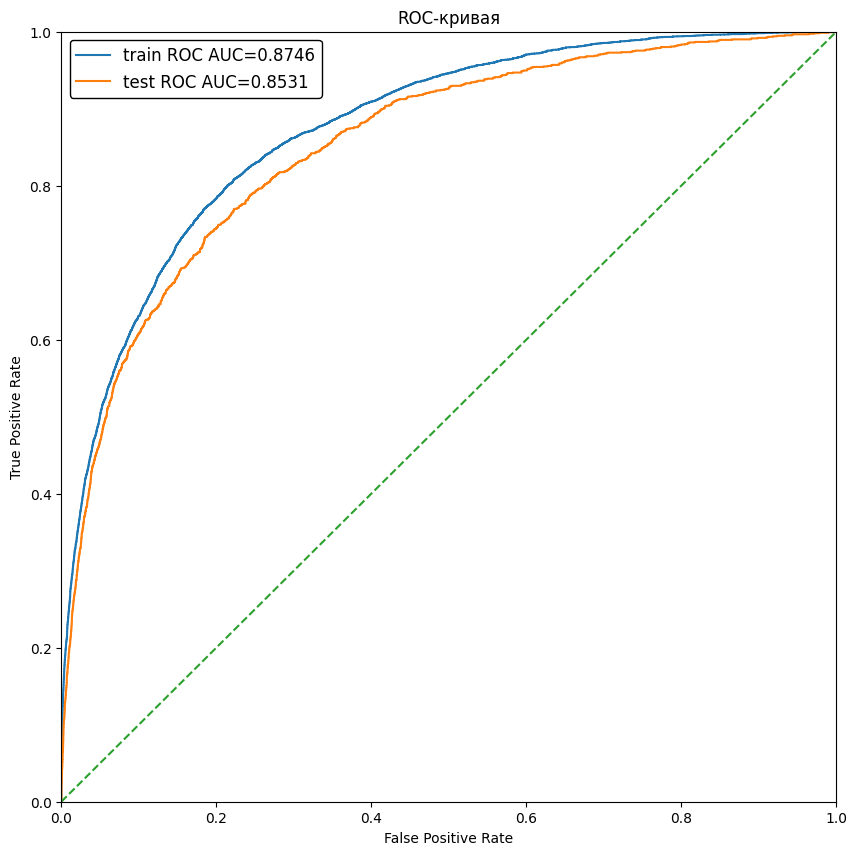

In [ ]:
ml_result(RFC_model,'RandomForestClassifier',X_train, X_valid, y_train, y_valid)

## Результаты всех моделей

In [ ]:
score_table = pd.DataFrame(models_score)
score_table.style.highlight_max('roc_auc', color = 'green', axis = 0)

,model_name,roc_auc,accuracy,precision,recall
0,LogisticRegression,0.831000,0.938958,0.642458,0.076260
1,GradientBoostingRegressor,0.852994,0.940048,0.597964,0.155836
2,CatBoost,0.854600,0.940592,0.613636,0.161141
3,RandomForestClassifier,0.853117,0.940383,0.641196,0.127984


# Дополнительно

Изобразите корреляционную матрицу для пар признаков, например, с помощью функции df.corr()

<AxesSubplot:>

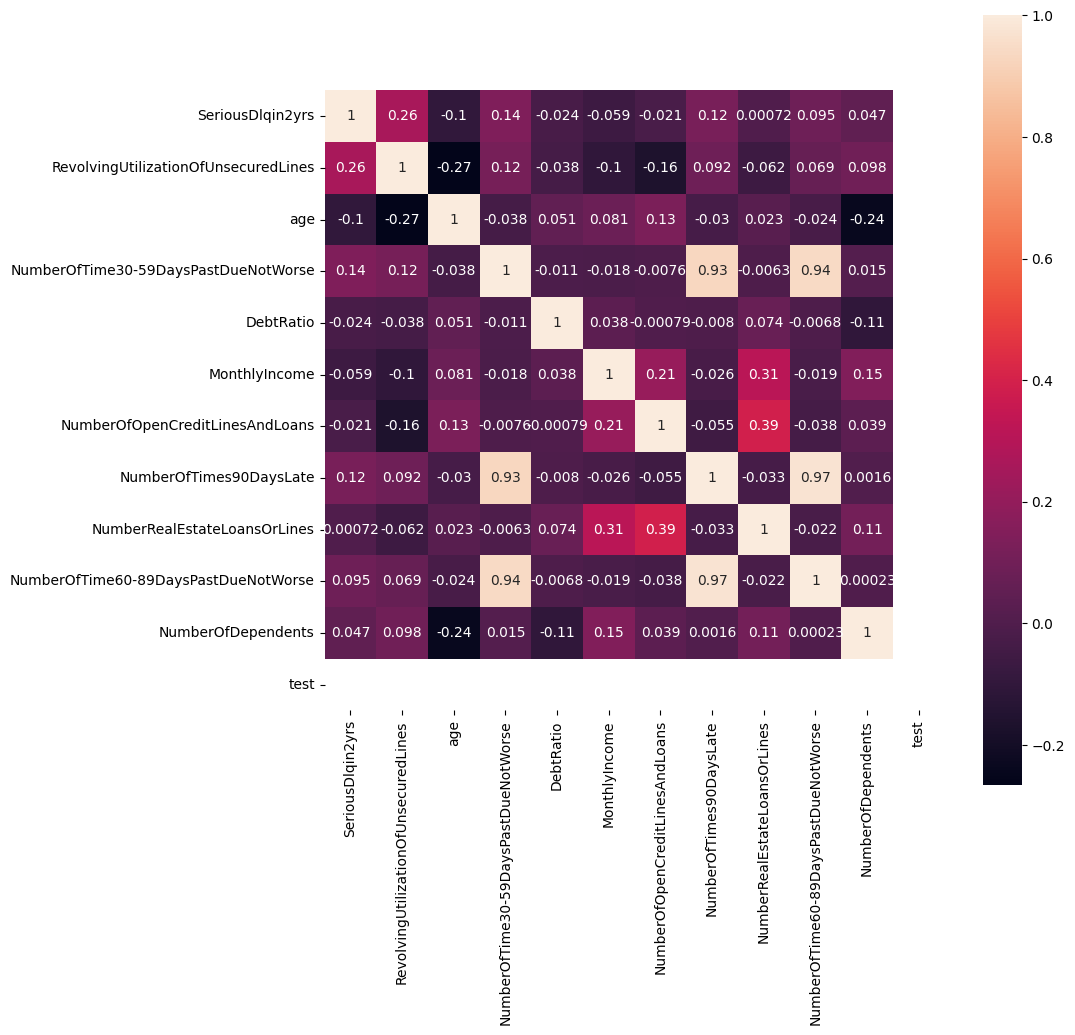

In [44]:
plt.figure(figsize=[10,10])
sns.heatmap(data_train.corr(), annot = True,square=True)

#Результат Kaggle

Запустите модель на тестовом наборе данных и загрузите результат на [Kaggle](https://www.kaggle.com/c/GiveMeSomeCredit/submit)

Самой сильной моделью себя показал CatBoost, поэтому его отправим на kaggle

In [ ]:
submission = pd.read_csv('C:/Users/Leo/Desktop/Misis/ML_1_sem/Project_1/sampleEntry.csv')
submission['Probability'] = (boosting_model.predict_proba(data_test)[:,1])
submission.to_csv('C:/Users/Leo/Desktop/Misis/ML_1_sem/Project_1/submission.csv',index=False)

Результат на Kaggle:

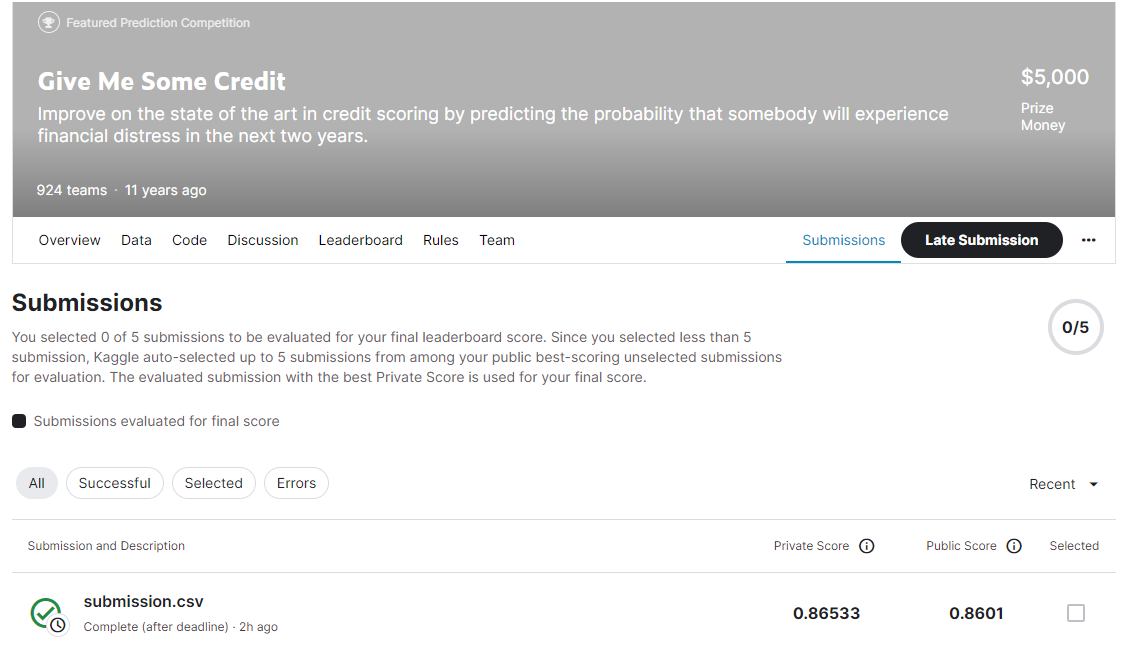

#Отчет

Напишите краткий отчет по полученным результатам. Объясните выбор модели, рассмотрите особенности данных


**Анализ данных.**

В данной задаче были проанализированы данные с помощью различных инструментов. Были выявлены пропуски в данных, они были заполнены средним значением по параметру модели. Так же были найдены выбросы. Заключительным этапом работы с данными была выполнина их нормализация, но только числовых признаков. 

**Обучение моделей**

Для обучения были выбраны 4 модели: LogisticRegression, GradientBoostingRegressor, CatBoost, RandomForestClassifier. Для сравнения моделей были выбраны 4 метрики ROC-AUC, accuracy, precision, recall. Благодаря такому набору метрик мы можем увидеть полную картину происходящего.

**Результат**

После обучения моделей была выведена таблица со всеми результатами. По метрике ROC-AUC выигрывает модель CatBoost. Данная модель очень тонко подается настройкам и хорошо работает «из коробки», чтобы позволяет быстро добиться желаемого результата.

**Kaggle**

Результат на Kaggle: **0.86533**
